## Chapter 12: Introduction to nonlinear learning

# 12.9 Ensembling methods

Intro goes here.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import basics_library 

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import math

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

#### <span style="color:#a50e3e;">Example 1. </span>  Bagging a prototuype nonlinear regression dataset

In [3]:
# load in dataset
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

In [4]:
num_pts = 17
r = np.random.permutation(y.size)[:num_pts]
x_samples = x[:,r]
y_samples = y[:,r]

Perform a k-fold split of the input data.

In [225]:
# function for splitting dataset into k folds
def split_data(y,num_folds):
    # split data into k equal (as possible) sized sets
    L = np.size(y)
    order = np.random.permutation(L)
    c = np.ones((L,1))
    L = int(np.round((1/num_folds)*L))
    for s in np.arange(0,num_folds-2):
        c[order[s*L:(s+1)*L]] = s + 2
    c[order[(num_folds-1)*L:]] = num_folds
    return c

In [229]:
num_folds = 3
c = split_data(y_samples,num_folds)

In [255]:
# This code cell will not be shown in the HTML version of this notebook
degree = 10
train_portion = 1/float(num_folds)
runs1 = []
for j in range(1,num_folds+1):
    # initialize with input/output data
    mylib1 = nonlib.reg_lib.super_setup.Setup(x_samples,y_samples)

    # perform preprocessing step(s) - especially input normalization
    mylib1.preprocessing_steps(normalizer = 'none')
    
    # pluck out indices of current training / validation sets
    val_inds = np.argwhere(c == (j))
    val_inds = [v[0] for v in val_inds]

    train_inds = np.argwhere(c != (j))
    train_inds = [v[0] for v in train_inds]
    
    # load this info into the model
    mylib1.train_inds = train_inds
    mylib1.val_inds = val_inds
    mylib1.x_train = mylib1.x[:,train_inds]
    mylib1.y_train = mylib1.y[:,train_inds]
    mylib1.x_val = mylib1.x[:,val_inds]
    mylib1.y_val = mylib1.y[:,val_inds]
    train_portion = 1/float(num_folds)
    mylib1.train_portion = train_portion
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib1.choose_cost(name = 'least_squares')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib1.choose_features(feature_name = 'polys',degree = d)

        # fit an optimization
        mylib1.fit(algo = 'newtons_method',max_its = 1,verbose = False)
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [mylib1.val_cost_histories[i][1] for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    
    mylib1.train_cost_histories = mylib1.train_cost_histories[min_ind][1]
    mylib1.val_cost_histories = mylib1.val_cost_histories[min_ind][1]
    mylib1.weight_histories = mylib1.weight_histories[min_ind][1]
    mylib1.choose_features(feature_name = 'polys',degree = min_ind + 1)

    # store 
    runs1.append(copy.deepcopy(mylib1))

<IPython.core.display.Javascript object>


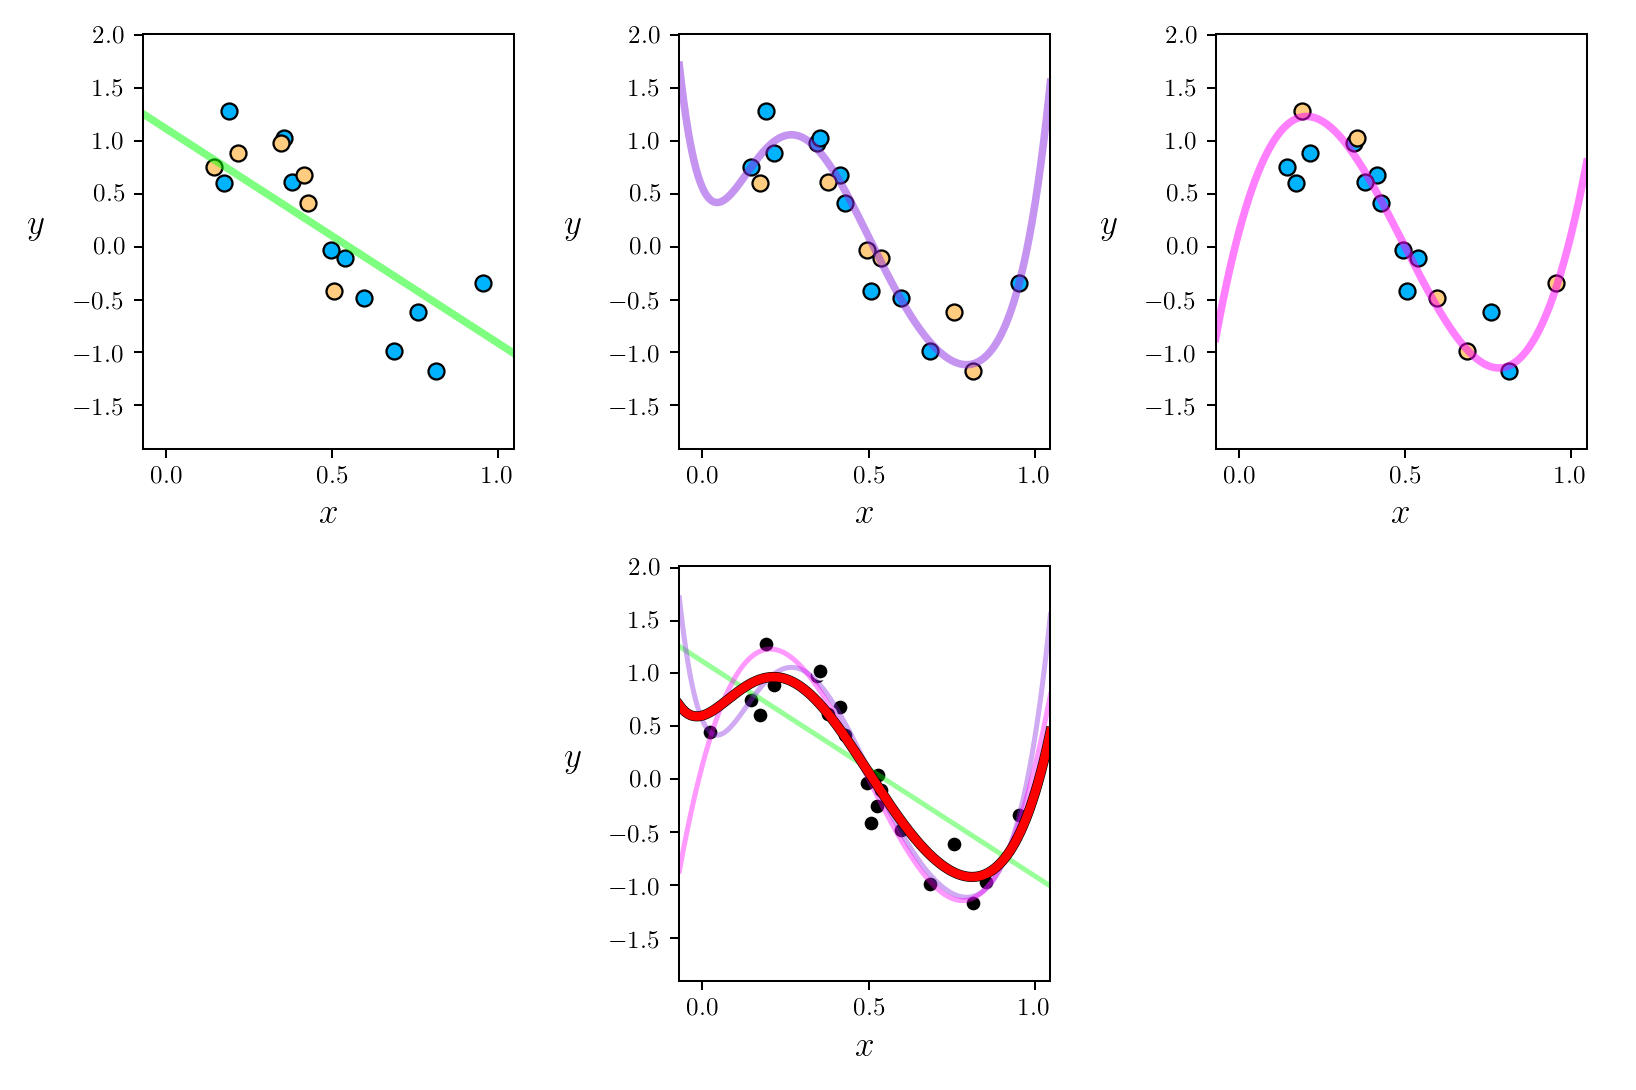

In [256]:
demo1 = nonlib.bagging_visualizers.Visualizer(csvname)
demo1.show_runs(runs1)

#### <span style="color:#a50e3e;">Example 1. </span>  Bagging a prototuype nonlinear regression dataset

In [24]:
# load in dataset
# csvname = datapath + 'universal_regression_samples_0.csv'
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# # remove lowest point
# ind = np.argmin(y)
# x = np.delete(x.flatten(), ind)[np.newaxis,:]
# y = np.delete(y.flatten(), ind)[np.newaxis,:]

# num_pts = 17
# r = np.random.permutation(y.size)[:num_pts]
# x_samples = x[:,r]
# y_samples = y[:,r]

In [26]:
# This code cell will not be shown in the HTML version of this notebook
degree = 10
num_baggs = 10
train_portion = 0.66
runs1 = []
for j in range(num_baggs):
    # initialize with input/output data
    mylib1 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib1.preprocessing_steps(normalizer = 'none')
    
    # pluck out indices of current training / validation sets
    mylib1.make_train_val_split(train_portion = train_portion)
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib1.choose_cost(name = 'least_squares')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib1.choose_features(feature_name = 'polys',degree = d)

        # fit an optimization
        mylib1.fit(algo = 'newtons_method',max_its = 1,verbose = False)
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [mylib1.val_cost_histories[i][1] for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    
    mylib1.train_cost_histories = mylib1.train_cost_histories[min_ind][1]
    mylib1.val_cost_histories = mylib1.val_cost_histories[min_ind][1]
    mylib1.weight_histories = mylib1.weight_histories[min_ind][1]
    mylib1.choose_features(feature_name = 'polys',degree = min_ind + 1)

    # store 
    runs1.append(copy.deepcopy(mylib1))

<IPython.core.display.Javascript object>


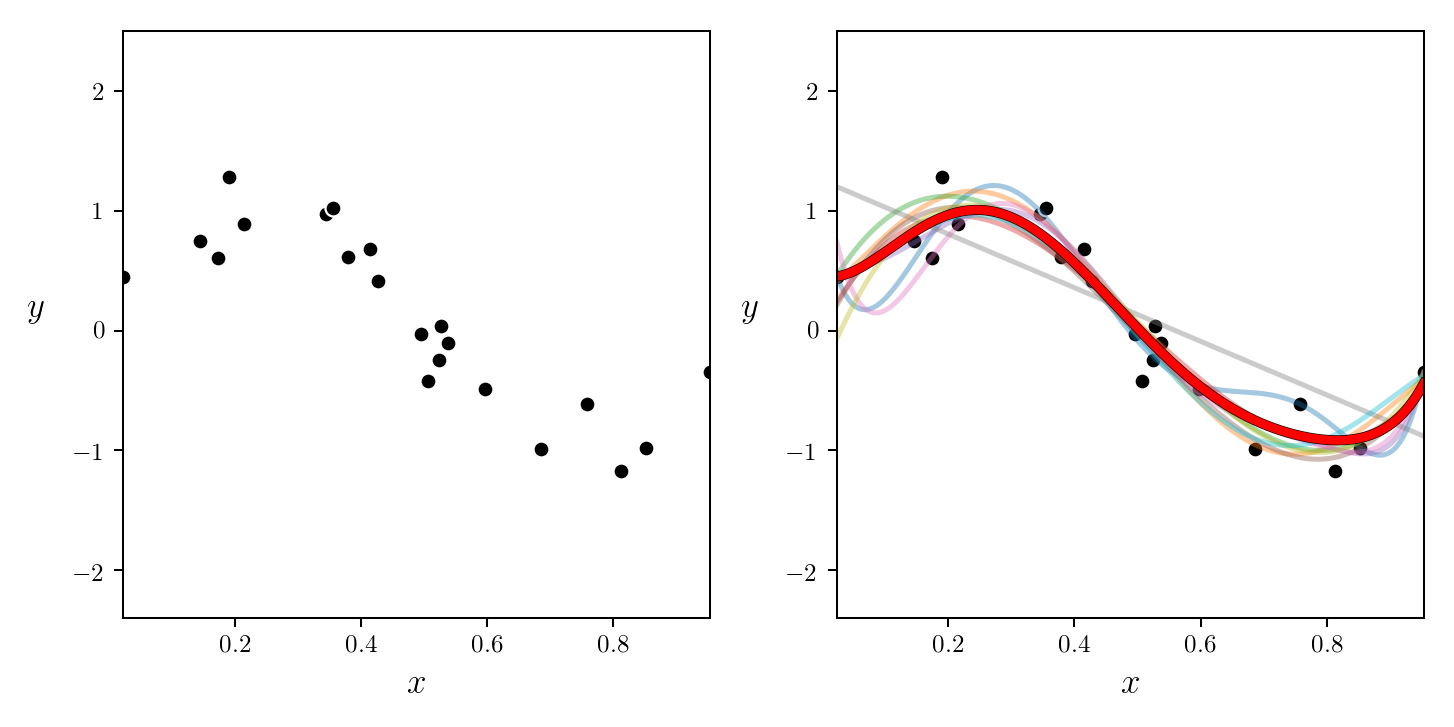

In [27]:
demo1 = nonlib.bagging_visualizers.Visualizer(csvname)
demo1.show_baggs(runs1)

#### <span style="color:#a50e3e;">Example 1. </span>  Bagging a prototuype nonlinear regression dataset